In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

Возьмем датасет с Олимпиады DLS https://drive.google.com/drive/folders/1WZr6XVEDLnNvwsNtFhWTC9yirY6n7Gri

In [2]:
train_data = pd.read_csv("fake_or_real_train.csv", index_col="id")
test_data = pd.read_csv("fake_or_real_test.csv", index_col="id")

In [3]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [4]:
X_train = train_data["text"]
y_train = train_data["label"]
X_test = test_data["text"]

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)
X_train.shape

(1440,)

<Axes: >

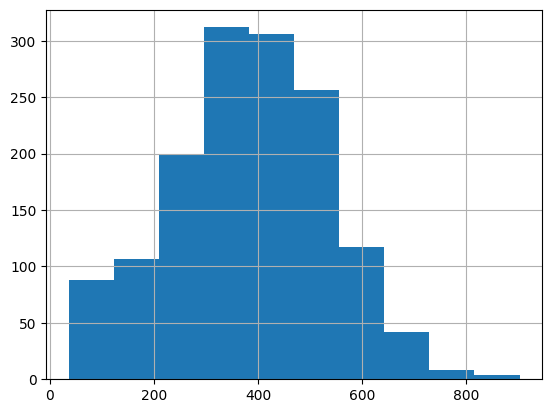

In [6]:
X_train.str.len().hist()

## TF-IDF + Random Forest

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train).toarray()
X_val = vectorizer.transform(X_val).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [8]:
X_train.shape

(1440, 10000)

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [11]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [14]:
val_predictions = model.predict(X_val)
accuracy_score(y_val, val_predictions)

0.9584487534626038

In [15]:
val_predictions_proba = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, val_predictions_proba)

0.9955996131528047

## Word2Vec + CatBoostClassifier

In [17]:
import gensim
from catboost import CatBoostClassifier

In [23]:
X_train_split = [sentence.split() for sentence in X_train]
X_val_split = [sentence.split() for sentence in X_val]

In [24]:
word2vec_model = gensim.models.Word2Vec(
    sentences=X_train_split, vector_size=500, window=10, min_count=1, workers=4
)

In [25]:
def vectorize_text(text_data, word2vec_model):
    vectors = []
    for sentence in text_data:
        vector = np.mean([ word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv ], axis=0)
        vectors.append(vector)
    return np.array(vectors)

In [26]:
X_train_w2v = vectorize_text(X_train_split, word2vec_model)
X_val_w2v = vectorize_text(X_val_split, word2vec_model)

In [27]:
X_train_w2v.shape

(1440, 500)

In [29]:
catboost = CatBoostClassifier(iterations=500, eval_metric='Accuracy')
catboost.fit(X_train_w2v, y_train, eval_set=(X_val_w2v, y_val))

Learning rate set to 0.046878
0:	learn: 0.8625000	test: 0.6509695	best: 0.6509695 (0)	total: 50.4ms	remaining: 25.1s
1:	learn: 0.8631944	test: 0.6509695	best: 0.6509695 (0)	total: 87.9ms	remaining: 21.9s
2:	learn: 0.8680556	test: 0.6509695	best: 0.6509695 (0)	total: 125ms	remaining: 20.7s
3:	learn: 0.8673611	test: 0.6481994	best: 0.6509695 (0)	total: 164ms	remaining: 20.3s
4:	learn: 0.8652778	test: 0.6454294	best: 0.6509695 (0)	total: 204ms	remaining: 20.2s
5:	learn: 0.8638889	test: 0.6565097	best: 0.6565097 (5)	total: 241ms	remaining: 19.9s
6:	learn: 0.8638889	test: 0.6481994	best: 0.6565097 (5)	total: 279ms	remaining: 19.7s
7:	learn: 0.8652778	test: 0.6565097	best: 0.6565097 (5)	total: 316ms	remaining: 19.4s
8:	learn: 0.8715278	test: 0.6620499	best: 0.6620499 (8)	total: 356ms	remaining: 19.4s
9:	learn: 0.8763889	test: 0.6703601	best: 0.6703601 (9)	total: 398ms	remaining: 19.5s
10:	learn: 0.8736111	test: 0.6814404	best: 0.6814404 (10)	total: 436ms	remaining: 19.4s
11:	learn: 0.8756944

In [30]:
accuracy_score(y_val, catboost.predict(X_val_w2v))

0.8116343490304709

In [31]:
roc_auc_score(y_val, catboost.predict_proba(X_val_w2v)[:, 1])

0.8911347517730497

## Bert

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-09-23 17:43:40.174948: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 17:43:41.743666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
import torch
from datasets import Dataset

In [8]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y_train)))

/home/jupyter/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

In [10]:
train_texts = [{"text": t} for t in X_train]
val_texts = [{"text": t} for t in X_val]

In [11]:
train_dataset = Dataset.from_dict({'text': X_train, 'labels': y_train})
val_dataset = Dataset.from_dict({'text': X_val, 'labels': y_val})

In [12]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 361/361 [00:00<00:00, 2169.25 examples/s]


In [13]:
len(next(iter(train_dataset))['input_ids'])

512

In [14]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [15]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
trainer = Trainer(
    model=model.cuda(),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: kwargs. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.7
wandb: Run data is saved locally in /home/jupyter/work/resources/wandb/run-20240923_174350-0npsdtou
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results
wandb: ⭐️ View project at https://wandb.ai/kwargs/huggingface
wandb: 🚀 View run at https://wandb.ai/kwargs/huggingface/runs/0npsdtou


ClearML Task: overwriting (reusing) task id=9901f234bb574930a96160c7218bd248
2024-09-23 17:43:57,895 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/1f5fc75d299a477a8d91405c27055e39/experiments/9901f234bb574930a96160c7218bd248/output/log
2024-09-23 17:44:00,830 - clearml.log - WARNING - Event reporting sub-process lost, switching to thread based reporting


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2024-09-23 17:44:01,667 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers/accelerator_config[AcceleratorConfig])


 92%|█████████▏| 11/12 [00:02<00:00,  3.44it/s]
                                                [A
100%|██████████| 12/12 [00:03<00:00,  3.18it/s]
                                               

{'eval_loss': 0.6328701972961426, 'eval_runtime': 3.4188, 'eval_samples_per_second': 105.591, 'eval_steps_per_second': 3.51, 'epoch': 1.0}


 92%|█████████▏| 11/12 [00:03<00:00,  3.37it/s]
                                                [A
100%|██████████| 12/12 [00:03<00:00,  3.36it/s]
                                               

{'eval_loss': 0.5421268343925476, 'eval_runtime': 3.4018, 'eval_samples_per_second': 106.119, 'eval_steps_per_second': 3.528, 'epoch': 2.0}


100%|██████████| 135/135 [02:12<00:00,  1.08it/s]